#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.\
\
Значение метрики RMSE на тестовой выборке должно быть не больше 48.\
\
Инструкция по выполнению проекта:

- Загрузите данные и выполните их ресемплирование по одному часу.
- Проанализируйте данные.
- Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
- Проверьте данные на тестовой выборке и сделайте выводы.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

import warnings
warnings.filterwarnings('ignore')

Загрузка данных

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('./taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Данные загружены и отсортированы по индексу, в качестве которого установлена дата. Пропусков нет.\
Мы имеем данные с 1 марта по 31 августа 2018 года с интервалом между значениями в 10 минут.

In [6]:
data.sort_index(inplace=True)

In [7]:
if data.index.is_monotonic_increasing:
    print("Индекс монотонно возрастающий.")
elif data.index.is_monotonic_decreasing:
    print("Индекс монотонно убывающий.")
else:
    print("Индекс не является монотонным.")


Индекс монотонно возрастающий.


Временные метки идут в хронологическом порядке без скачков назад или пропусков


Ресемплируем данные по одному часу, так как нам требуется предсказывать количество заказов на следующий час.

In [8]:
data = data.resample('1h').sum()

In [9]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


После ресемплирования датасет имеет 4416 строк.

Посмотрим как менется спрос на графике.

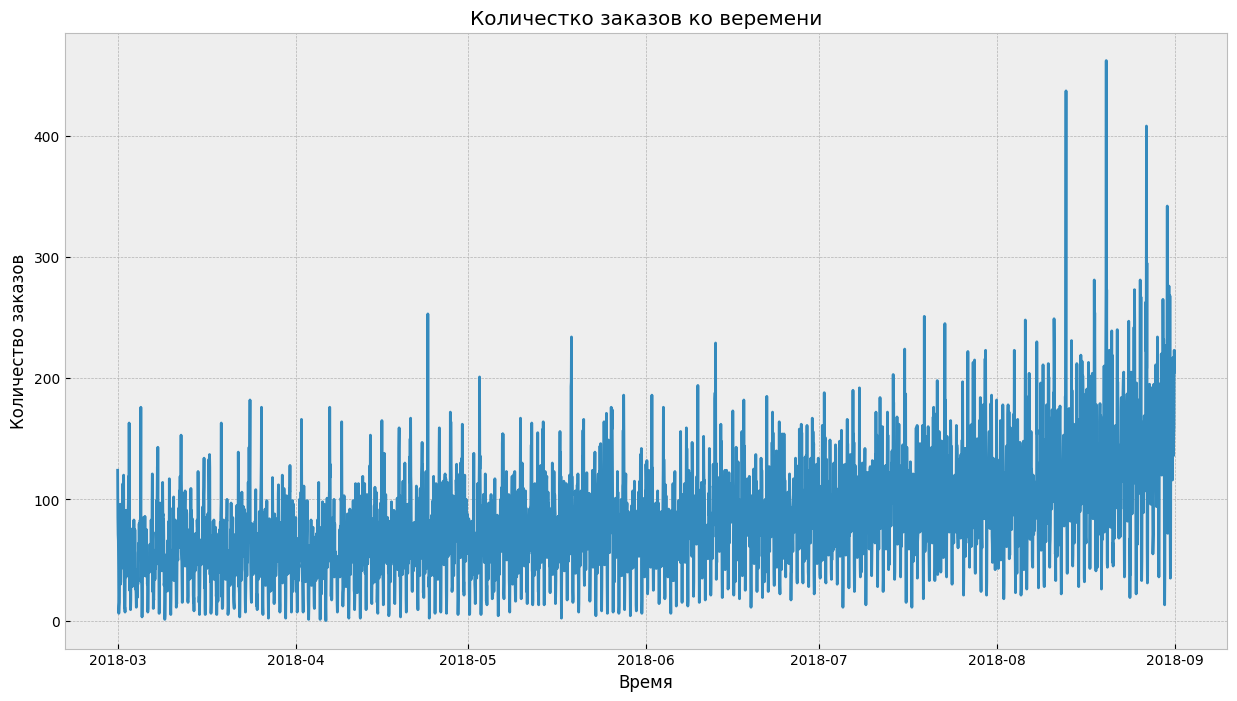

In [10]:
plt.style.use('bmh')
plt.figure(figsize=(15,8))
plt.title('Количестко заказов ко веремени')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.plot(data)
plt.show()

Наблюдается сильный разброс данных, попробуем метод скользящего среднего.

In [11]:
data_1 = data.copy()

In [12]:
data_1['rolling_mean'] = data_1['num_orders'].rolling(40, closed='left').mean()

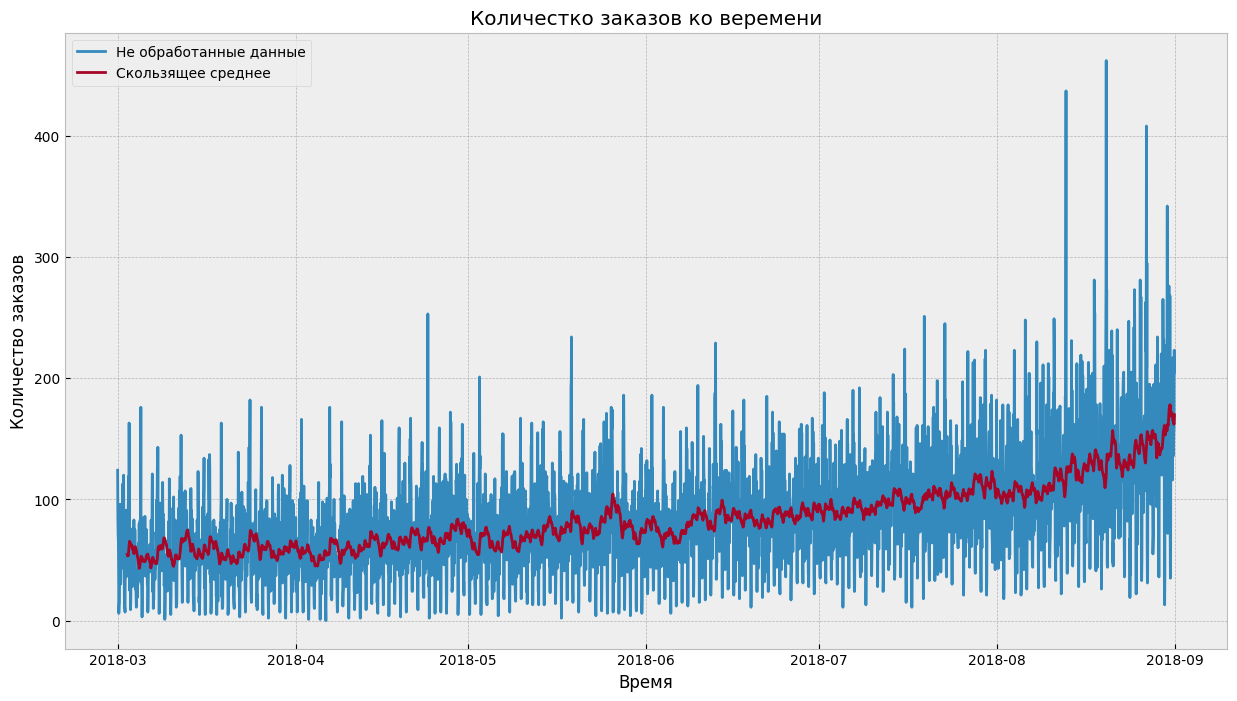

In [13]:

plt.figure(figsize=(15,8))
plt.title('Количестко заказов ко веремени')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.plot(data_1['num_orders'], label='Не обработанные данные')
plt.plot(data_1['rolling_mean'], label='Скользящее среднее')
plt.legend()
plt.show()

На графике можно увидеть, что среднее со временем возрастает.

Посмотрим на сезоннсоть и тренды.

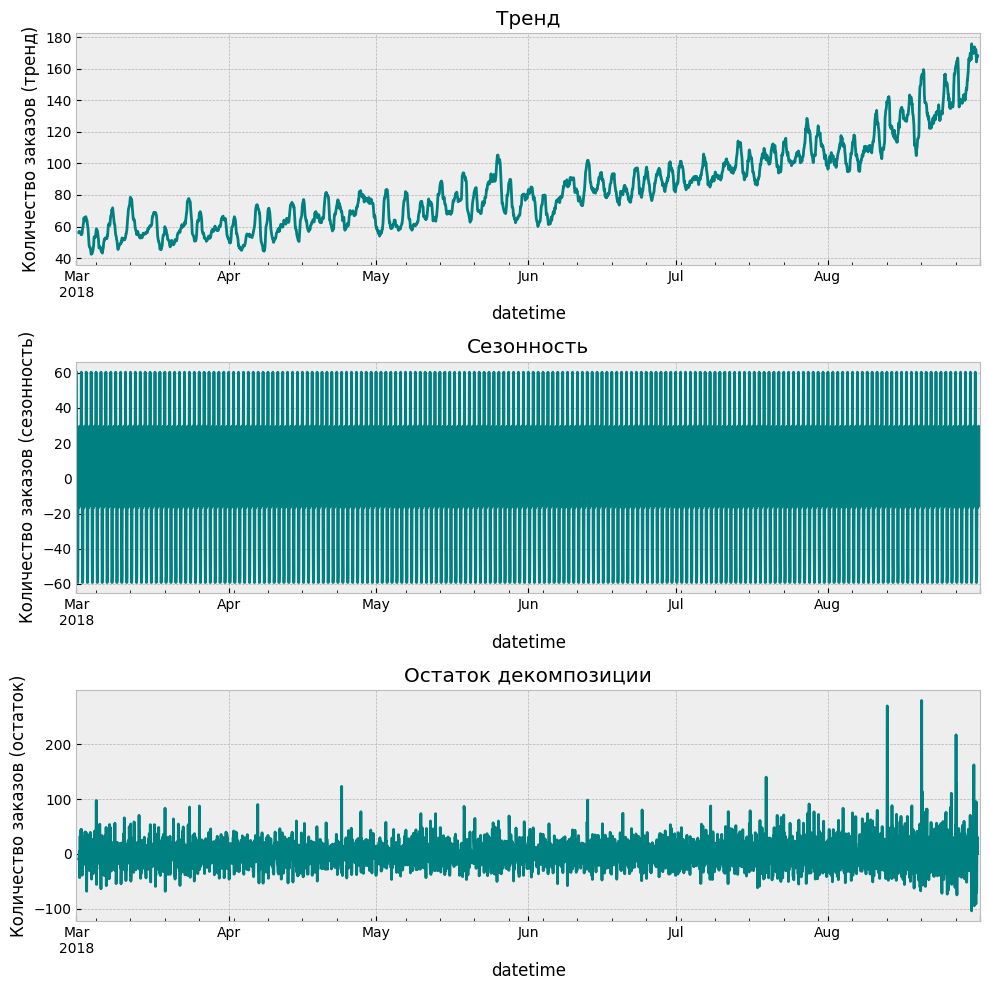

In [14]:
decomposed = seasonal_decompose(data)

plt.figure(figsize=(10, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), color='teal')
plt.title('Тренд')
plt.ylabel('Количество заказов (тренд)')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca(), color='teal')
plt.title('Сезонность')
plt.ylabel('Количество заказов (сезонность)')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), color='teal')
plt.title('Остаток декомпозиции')
plt.ylabel('Количество заказов (остаток)')

plt.tight_layout()


Видно наличие явного тренда на увеличение количества заказов такси в целом, с марта по август. Так же можно отметить что количество заказов значительней увеличивается в летние месяцы, особенно в августе, - на этот период приходится пик летних отпусков, поэтому люди чаще летают самолетом и заказывают такси до аэропорта.\
График, отображающий сезонность, не подходит для анализа (не 'читается'). Т.к. исследуемый период охватывает всего шесть месяцев. Рассмотрим суточную сезонность.\
Остаток декомпозиции - это шумовые данные, анализировать их смысла нет.

Cезонность за двое суток

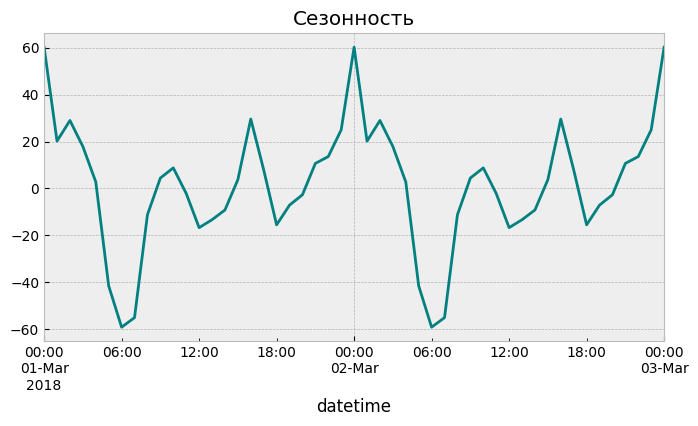

In [15]:
plt.figure(figsize=(8, 4))
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-03 00:00:00'].plot(ax=plt.gca(), color = 'teal')
plt.title('Сезонность');

Сезонность графика имеет цикличность с периодом в 24 часа. Пик заказов такси приходится на 00:00, а минимум на 6:00.

Проведем дополнительную проверку датасета на стационарность. Для этого найдём стандартное отклонение по скользящему окну.

In [16]:
data_1['rolling_std'] = data_1['num_orders'].rolling(40, closed='left').std()

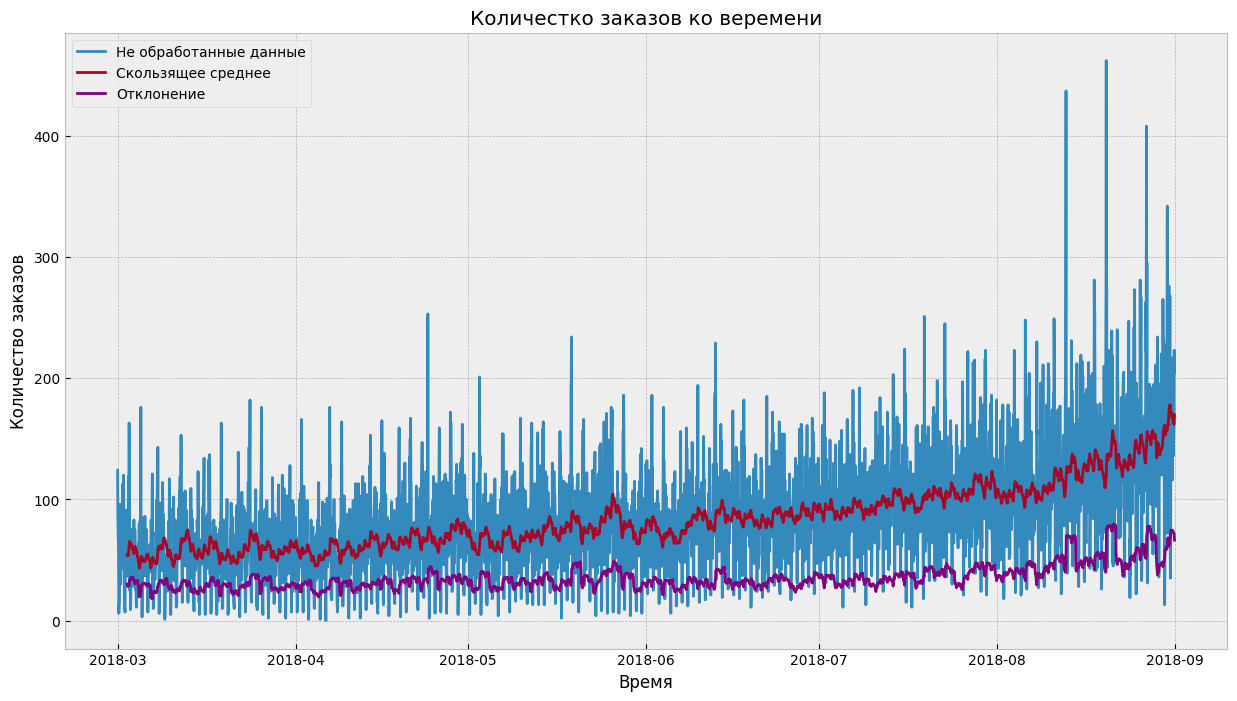

In [17]:
plt.figure(figsize=(15,8))
plt.title('Количестко заказов ко веремени')
plt.xlabel('Время')
plt.ylabel('Количество заказов')

plt.plot(data_1['num_orders'], label='Не обработанные данные')
plt.plot(data_1['rolling_mean'], label='Скользящее среднее')
plt.plot(data_1['rolling_std'], label='Отклонение', color = '#800080')
plt.legend()
plt.show()



По графику видно, что стандартное отклонение, как и скользящее среднееб со временем возрастают. Значит ряд является нестационарным.

Тест Дики-Фуллера.\
\
Гипотезы:

- Нулевая гипотеза H0: Ряд нестационарен (имеет единичный корень). 
- Альтернативная гипотеза H1: Ряд стационарен.

Мы будем проверять результат на уровнях значимости 1% и 5%.

In [18]:
adf_result = adfuller(data_1['num_orders'])

# Вывод результатов теста
print('Результаты теста Дики-Фуллера:')
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Критические значения:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

alpha = 0.05  
if adf_result[1] < alpha:
    print("Отвергаем нулевую гипотезу (ряд стационарен)")
else:
    print("Не можем отвергнуть нулевую гипотезу (ряд нестационарен)")

alpha_1 = 0.01
if adf_result[1] < alpha_1:
    print("Отвергаем нулевую гипотезу на уровне 1% (ряд стационарен)")
else:
    print("Не можем отвергнуть нулевую гипотезу на уровне 1% (ряд нестационарен)")

Результаты теста Дики-Фуллера:
ADF Statistic: -3.0689242890279576
p-value: 0.0289400514026128
Критические значения:
   1%: -3.431842162413052
   5%: -2.8621993540813637
   10%: -2.567120978470452
Отвергаем нулевую гипотезу (ряд стационарен)
Не можем отвергнуть нулевую гипотезу на уровне 1% (ряд нестационарен)


Уровень значимости 5%: 
- p-value (0.02894) < 0.05
- ADF Statistic (-3.0689) < Критическое значение 5% (-2.8622)

Мы отвергаем нулевую гипотезу о нестационарности ряда. Это означает, что ряд стационарен на уровне значимости 5%.\
\
Уровень значимости 1%:
- p-value (0.02894) > 0.01
- ADF Statistic (-3.0689) > Критическое значение 1% (-3.4318)

 Мы не можем отвергнуть нулевую гипотезу на уровне значимости 1%. То есть, на этом уровне уверенности ряд нестационарен.

## Обучение

Создадим новые признаки для построения моделей. Сгенерируем месяц, день, день недели и час. Также добавим предыдущие значения и скользящее среднее.

In [22]:
def make_features(data, max_lag, rolling_mean_size):
    data_copy = data.copy()

    data_copy['day'] = data_copy.index.day
    data_copy['dayofweek'] = data_copy.index.dayofweek
    data_copy['hour'] = data_copy.index.hour
    
    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data_copy['num_orders'].shift(lag)
    
    data_copy['rolling_mean'] = data_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_copy

### Проверка на адекватность

Для проверки на адекватность создадим модель предсказания значения по предыдущему значению ряда.

In [23]:
RS = 2033

In [24]:
train, test = train_test_split(data, shuffle=False, test_size=0.1, random_state = RS)
print(train.shape)
print(test.shape)

(3974, 1)
(442, 1)


In [25]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
RMSE_dummy = mean_squared_error(test, pred_previous)**0.5
print("RMSE:", RMSE_dummy)

RMSE: 58.856486242815066


RMSE = 58, с этим значением мы будем сравнивать наши будущие модели.

### Линейная регрессия

In [27]:
%%time
best_lag_lr = 0
best_rolling_size_lr = 0
best_rmse_lr = 48 

tss = TimeSeriesSplit(n_splits=5)

for lag in range (1, 100, 10):
    for roll in range(1, 100, 10):
        data_lr = make_features(data, lag, roll)
        train, test = train_test_split(data_lr, shuffle=False, test_size=0.1, random_state = RS)
        train = train.dropna()
        X_train = train.drop(['num_orders'], axis=1)
        y_train = train['num_orders']
        X_test = test.drop(['num_orders'], axis=1)
        y_test = test['num_orders']
      
        model_lr = LinearRegression(fit_intercept=False, copy_X=True)
        model_lr.fit(X_train, y_train)

        neg_mse_scores = cross_val_score(model_lr, X_train, y_train, cv=tss, scoring='neg_mean_squared_error', n_jobs=-1)
        rmse_scores = np.sqrt(-neg_mse_scores)
        mean_rmse = rmse_scores.mean()

        if mean_rmse < best_rmse_lr:
            best_rmse_lr = mean_rmse
            best_lag_lr = lag
            best_rolling_size_lr = roll

print(f'Лучшее RMSE на кроссвалидации: {best_rmse_lr:.2f}, '
      f'Размер смещения: {best_lag_lr}, '
      f'Размер скользящего окна: {best_rolling_size_lr}')


Лучшее RMSE на кроссвалидации: 24.01, Размер смещения: 81, Размер скользящего окна: 71
CPU times: total: 10.5 s
Wall time: 14.1 s


### Случайный лес

In [28]:
%%time
best_lag_rf = 0
best_rolling_size_rf = 0
best_rmse_rf = 48
for lag in range (31, 61, 10):
    for roll in range(1, 11, 10):
        data_rf = make_features(data, lag, roll)
        train, test = train_test_split(data_rf, shuffle=False, test_size=0.1, random_state = RS)
        train = train.dropna()
        X_train = train.drop(['num_orders'], axis=1)
        y_train = train['num_orders']
        X_test = test.drop(['num_orders'], axis=1)
        y_test = test['num_orders']
        
        model_rf = RandomForestRegressor()
        param_grid = {
            'max_depth': range(11, 31, 5)
            }
        grid = GridSearchCV(model_rf, 
                            param_grid, 
                            scoring = 'neg_mean_squared_error',  
                            cv = tss, 
                            n_jobs = -1)
        grid.fit(X_train, y_train)
        rmse = (-grid.best_score_) ** 0.5 
        if rmse < best_rmse_rf:
            best_rmse_rf = rmse
            best_lag_rf = lag
            best_rolling_size_rf = roll
        
            
print('RMSE на кроссвалидации: {:.2f}, Размер смещения: {:.0f}, Размер скользящего окна: {:.0f} '.format(best_rmse_rf, best_lag_rf, best_rolling_size_rf))
params_rf = grid.best_params_
print('Наилучшие параметры для модели:', params_rf)

RMSE на кроссвалидации: 24.74, Размер смещения: 51, Размер скользящего окна: 1 
Наилучшие параметры для модели: {'max_depth': 21}
CPU times: total: 25.4 s
Wall time: 1min 18s


### CatBoost

In [29]:
%%time
best_lag_cb = 0
best_rolling_size_cb = 0
best_rmse_cb = 48
for lag in range (11, 21, 10):
    for roll in range(11, 21, 10):
        data_cb = make_features(data, lag, roll)
        train, test = train_test_split(data_cb, shuffle=False, test_size=0.1, random_state = RS)
        train = train.dropna()
        X_train = train.drop(['num_orders'], axis=1)
        y_train = train['num_orders']
        X_test = test.drop(['num_orders'], axis=1)
        y_test = test['num_orders']
        
        model_cb = CatBoostRegressor(iterations = 100, verbose = False)
        param_grid = {
            'learning_rate': [0.6, 0.8],
            'depth': [5, 10],
            'iterations': [10, 20]
            
            }
        
        grid = GridSearchCV(model_cb, 
                            param_grid, 
                            scoring = 'neg_mean_squared_error',  
                            cv = tss, 
                            n_jobs = -1)
        grid.fit(X_train, y_train)
        rmse = (-grid.best_score_) ** 0.5
        if rmse < best_rmse_cb:
            best_rmse_cb = rmse
            best_lag_cb = lag
            best_rolling_size_cb = roll
                
            
print('RMSE на кроссвалидации: {:.2f}, Размер смещения: {:.2f}, Размер скользящего окна: {:.2f} '.format(best_rmse_cb, best_lag_cb, best_rolling_size_cb))
params_cb = grid.best_params_
print('Наилучшие параметры для модели:', params_cb)

RMSE на кроссвалидации: 27.03, Размер смещения: 11.00, Размер скользящего окна: 11.00 
Наилучшие параметры для модели: {'depth': 5, 'iterations': 20, 'learning_rate': 0.6}
CPU times: total: 172 ms
Wall time: 4.8 s


In [30]:
result = {'model': ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor'],
        'RMSE': [best_rmse_lr, best_rmse_rf, best_rmse_cb]}

models_results = pd.DataFrame(result)
models_results

,model,RMSE
0,LinearRegression,24.009199
1,RandomForestRegressor,24.740082
2,CatBoostRegressor,27.031345


**Вывод**

Мы обучили константную модель, для проверки наших основных моделей на адекватность, предсказывающую по последнему значению ряда с RMSE = 58,8.
\
Все наши модели прошли проверку на адекватность, лучше всего себя показала модель `LinearRegression`, выберем ее для финального тестирования.

In [31]:
df = make_features(data, best_lag_lr, best_rolling_size_lr)

train, test = train_test_split(df, shuffle=False, test_size=0.1, random_state = RS)
train = train.dropna()

X_train = train.drop(['num_orders'], axis = 1)
y_train = train['num_orders']
X_test = test.drop(['num_orders'], axis = 1)
y_test =test['num_orders']

model = LinearRegression(fit_intercept=False, copy_X=True)
model.fit(X_train, y_train)
predict = model.predict(X_test)
rmse = (mean_squared_error(y_test, predict))**0.5 
print('RMSE тестовой выборки: {:.2f}'.format(rmse))

RMSE тестовой выборки: 40.87


Результат получился не самый лучший, но главное что он проходит необходимый порог.

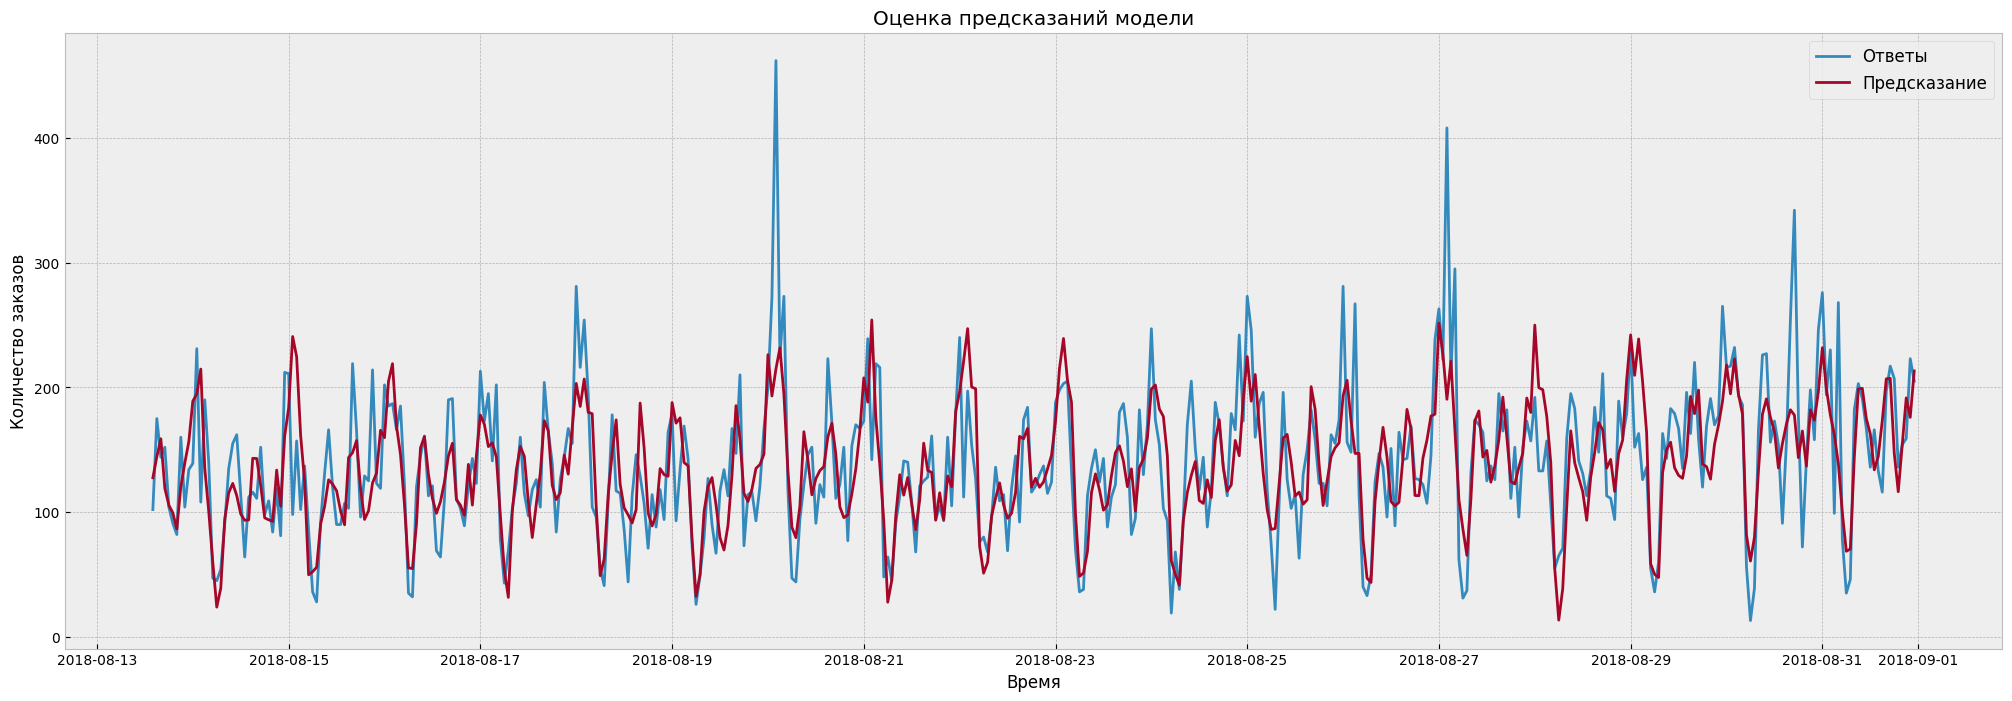

In [33]:
plt.figure(figsize=(25,8))
plt.title('Оценка предсказаний модели')
plt.xlabel('Время')
plt.ylabel('Количество заказов')
plt.plot(y_test, label='Ответы')
plt.plot(y_test.index, model.predict(X_test), label='Предсказание')
plt.legend(loc='best', fontsize=12)
plt.show()

Как видно, моедль достаточно хорошо попадает в "ритм" ответов, но не справляется с большими выбросами.

**ВЫВОД**

*В ходе выполнения проекта были загружены данные о количестве заказов такси в 10-минутные промежутки с марта по август 2018 года. Этот временной ряд был ресемплирован по интервалу в один час, затем была проанализирована сезонность и тренды временного ряда, сгенерированы новые признаки для обучения.*

*Для задачи предсказания количества заказов такси с горизонтом планирования в один час были обучены модели линейной регрессии, случайного леса и градиентного бустинга. Лучший результат дала модель LinearRegression.*

*RMSE на тестовой выборке = 40.87*